In [ ]:
from pathlib import Path
import tarfile
import urllib.request
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.tree import plot_tree

from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")

    return pd.read_csv(Path("datasets/housing/housing.csv"))

#- This comes from 0.4SGDRegressor_housing

def split_train_test(X, y, test_ratio = 0.2):

    #---stratified sampling
    X_columns = X.columns
    y_columns = y.columns
    data = pd.concat([X,y], axis = 1)


    df_income_cat = data.copy()
    df_income_cat["income_cat"] = pd.cut(df_income_cat["median_income"],
                                       bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                       labels=[1, 2, 3, 4, 5])

    dftrain_strat, dftest_strat = train_test_split(
        df_income_cat, test_size=test_ratio, stratify=df_income_cat["income_cat"], random_state=42)

    dftrain_strat = dftrain_strat.drop(['income_cat'], axis = 1)
    dftest_strat = dftest_strat.drop(['income_cat'], axis = 1)

    X_train = dftrain_strat[X_columns]
    y_train = dftrain_strat[y_columns]

    X_test = dftest_strat[X_columns]
    y_test = dftest_strat[y_columns]

    return X_train, X_test, y_train, y_test

Xtrain_prepared_column_names = []

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]


def fill_na(X, strategy = 'median'):
    #X: ndarray array of shape (n_samples, n_features)
    #return ndarray of shape (n_samples, n_features) with missing values filled by the strategy

    imputer = SimpleImputer(strategy = strategy)
    imputer.fit(X)

    return imputer.transform(X)

def get_outlier_indices(X):
    #X: ndarray of shape (n_samples, n_features)
    #y: label of shape (n_samples, k = 1)
    #return the indices of outliers in X

    isolation_forest = IsolationForest(random_state = 42)
    outlier_pred = isolation_forest.fit_predict(X)

    return outlier_pred

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name))


def prepare_for_train(Xtrain, Xtest, ytrain, ytest):

    #prepare data for training
    #---create 2 pipelines for nummerical columns and catergorical columns
    #---then merge them into one
    num_pipeline = make_pipeline(SimpleImputer(strategy = 'median'),\
                                 StandardScaler())

    cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"),\
                                 OneHotEncoder(handle_unknown='ignore'))


    # Must add the columns bedrooms, rooms_per_house, and people_per_house

    preprocessing = ColumnTransformer([("num", num_pipeline, make_column_selector(dtype_include=np.number)),\
                                       ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
                                       ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
                                       ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
                                       ("people_per_house", ratio_pipeline(), ["population", "households"])



                                      ])



    #---pass Xtrain, Xtest thru the pipeline to get the prepared versions


    Xtrain_prepared = preprocessing.fit_transform(Xtrain, ytrain)
    Xtest_prepared = preprocessing.fit_transform(Xtest, ytest)


    ytrain_prepared, ytest_prepared = ytrain, ytest

    ytrain_prepared, ytest_prepared = np.ravel(ytrain_prepared, ), np.ravel(ytest_prepared, )




    global Xtrain_prepared_col_names
    Xtrain_prepared_col_names = preprocessing.get_feature_names_out()


    return Xtrain_prepared, Xtest_prepared, ytrain_prepared, ytest_prepared

In [ ]:
housing = load_housing_data() # housing is a dataframe

housing_X = housing.drop("median_house_value", axis=1)
housing_y = housing[["median_house_value"]].copy()

#Test ratio is .25 because the dev to train ratio is 1/4.

Xtrain, Xtest, ytrain, ytest = split_train_test(housing_X, housing_y, test_ratio = 0.25)


Xtrain_pre, Xtest_pre, ytrain_pre, ytest_pre = prepare_for_train(Xtrain, Xtest, ytrain, ytest)

In [ ]:
Xdev, ydev = Xtrain_pre[50000:], ytrain_pre[50000:]

In [ ]:
tf.random.set_seed(42)

model = Sequential()

# input layer
model.add(Dense(19,activation='relu'))

# hidden layers
model.add(Dense(500,activation='relu'))
Dropout(0.2)
model.add(Dense(200,activation='relu'))
model.add(Dense(19,activation='relu'))


model.add(Dense(1))

model.compile(optimizer='adam',loss='mse', metrics = ['accuracy'])



#kernel_regularizer = regulaizer.;2(0.001)


#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Input(shape=[16, 16]))
#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(300, activation="relu"))
#model.add(tf.keras.layers.Dense(100, activation="relu"))
#model.add(tf.keras.layers.Dense(10, activation="softmax"))

#model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

#model.summary()

In [ ]:
model.fit(x=Xtrain_pre,y=ytrain_pre,
          validation_data=(Xtest_pre,ytest_pre),
          batch_size=128,epochs=1000)








#model.compile(optimizer = "adam",
#              loss="sparse_categorical_crossentropy",
#              metrics=["accuracy"])
#
#history = model.fit(Xtrain_pre, ytrain_pre, validation_data=(Xtest_pre, ytest_pre),
#                    epochs = 50, verbose = 'auto', batch_size = 64)

Epoch 1/1000
121/121 [==============================] - 3s 15ms/step - loss: 52633038848.0000 - accuracy: 0.0000e+00 - val_loss: 42494554112.0000 - val_accuracy: 0.0000e+00
Epoch 2/1000
121/121 [==============================] - 2s 12ms/step - loss: 16376652800.0000 - accuracy: 0.0000e+00 - val_loss: 84434100224.0000 - val_accuracy: 0.0000e+00
Epoch 3/1000
121/121 [==============================] - 1s 8ms/step - loss: 11335915520.0000 - accuracy: 0.0000e+00 - val_loss: 67969814528.0000 - val_accuracy: 0.0000e+00
Epoch 4/1000
121/121 [==============================] - 1s 8ms/step - loss: 9546106880.0000 - accuracy: 0.0000e+00 - val_loss: 62911995904.0000 - val_accuracy: 0.0000e+00
Epoch 5/1000
121/121 [==============================] - 1s 8ms/step - loss: 8418442240.0000 - accuracy: 0.0000e+00 - val_loss: 57696616448.0000 - val_accuracy: 0.0000e+00
Epoch 6/1000
121/121 [==============================] - 1s 8ms/step - loss: 7557957632.0000 - accuracy: 0.0000e+00 - val_loss: 49566674944.0

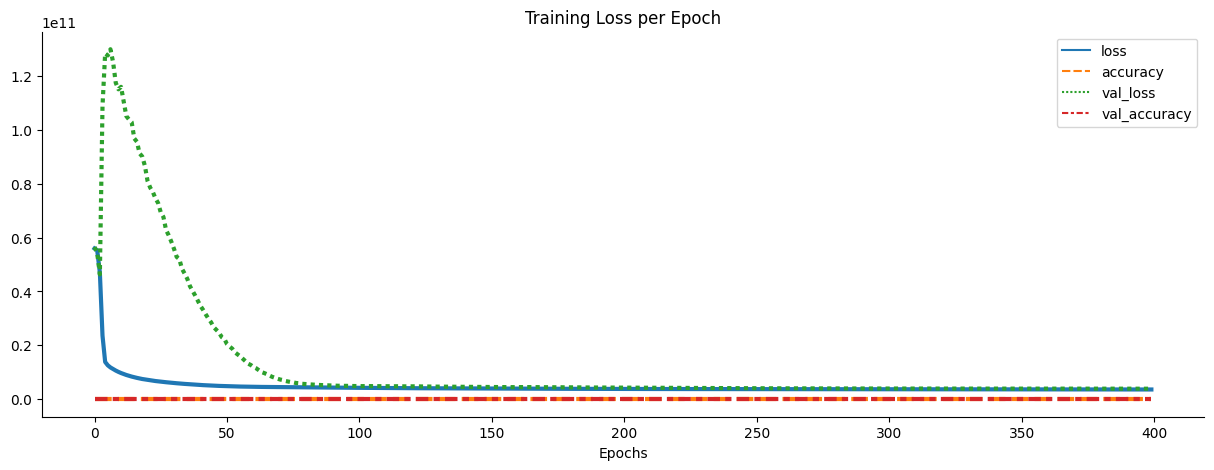

In [ ]:
losses = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5))
sns.lineplot(data=losses,lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Loss per Epoch')
sns.despine()

In [ ]:
predictions = model.predict(Xtest_pre)

print('MAE: ',mean_absolute_error(ytest_pre,predictions))
print('MSE: ',mean_squared_error(ytest_pre,predictions))
print('RMSE: ',np.sqrt(mean_squared_error(ytest_pre,predictions)))

162/162 [==============================] - 0s 2ms/step
MAE:  42196.93630465722
MSE:  3889823069.7451534
RMSE:  62368.446106546166


In [ ]:
import numpy as np

# Define an acceptable percentage error
acceptable_error = 0.10

# Calculate whether each prediction is within the acceptable range
correct_predictions = np.abs(predictions.flatten() - ytest_pre) <= acceptable_error * ytest_pre

# Calculate the error rate
error_rate = 1 - np.mean(correct_predictions)
print(f"Error rate: {error_rate:.2%}")


Error rate: 66.92%
